In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas import DataFrame, Series
import pandas_datareader.data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
import datetime as date
from matplotlib import font_manager, rc

# 한글 문제 해결
try:
    path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    fontprop = font_manager.FontProperties(fname=path, size=18).get_name()
    rc('font', family='NanumGothicCoding')
except: pass

In [2]:
'''외국인 누적 순매수'''
Frn = pd.read_csv('data/foreign.csv', header=None, index_col= [0])
Frn.index = [pd.to_datetime(date.replace('월',''), format = '%Y%m') for date in Frn.index]
Frn.columns = ['Cummul']

In [3]:
net_buy_ls = [np.nan] + list(np.array(Frn['Cummul'].iloc[1:]) - np.array(Frn['Cummul'].iloc[:-1]))

In [5]:
Frn['Net_buy'] = net_buy_ls

[*********************100%***********************]  1 of 1 downloaded
KOSPI 자료를 가져오는데 성공하였습니다.


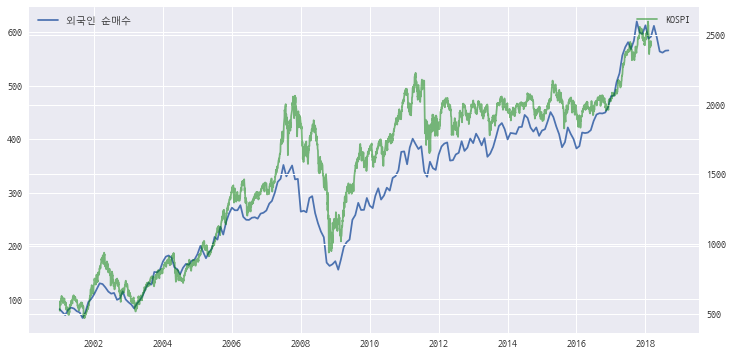

In [6]:
#foreign['Cummul'] = foreign['Net_buy'].cumsum()

fig, ax = plt.subplots(figsize = (12,6))
ax.plot(Frn['Cummul'], label = '외국인 순매수')


'''코스피 지수'''
start = date.datetime(2001,1,1)
end = date.datetime(2018,3,1)

for i in range(10):
    try:
        kospi = pdr.get_data_yahoo('^KS11', start,end)
        
        if not kospi.empty :
            print('KOSPI 자료를 가져오는데 성공하였습니다.')
            break

    except:
        print('KOSPI 자료를 가져오는데 실패하였습니다.')
    
    
    
ax2 = ax.twinx()
ax2.plot(kospi['Adj Close'], color = 'green', label = 'KOSPI', alpha = 0.5)
ax.legend(loc = 'upper left')
ax2.legend(loc= 'upper right')

Text(0.5,1,'매매 구간  1 : 매수  -1 : 매도 ')

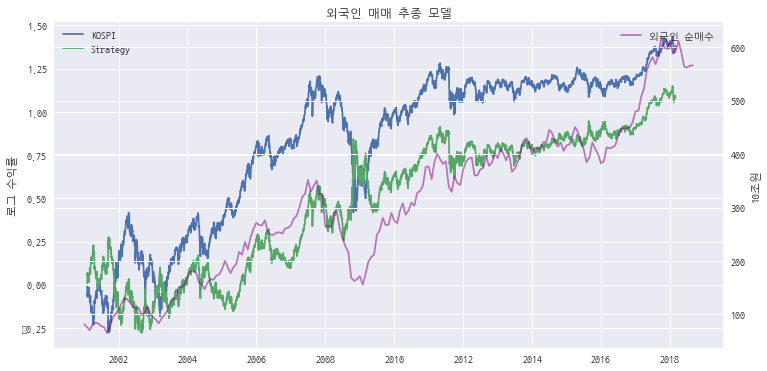

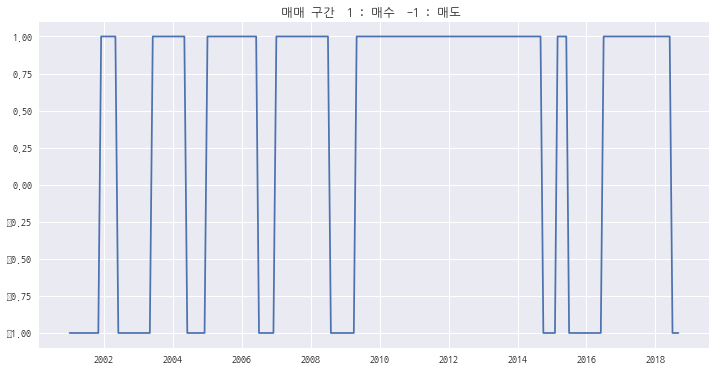

In [7]:
''' 매매 신호를 찾기 위해 외국인 순매수의 증가, 감소 추세를 확인한다

    Regime0 : 전월 대비                 (0: 감소, 1: 증가)
    Regime1 : 2개월전 & 1개월 전 비교    (0: 감소, 1: 증가)
    Regime2 : 3개월전 & 2개월 전 비교    (0: 감소, 1: 증가)'''

# i = [0,1,2]
for i in range(3):
    Frn['Regime%d'%i] = np.where(Frn['Cummul'].shift(i) - Frn['Cummul'].shift(1+i) > 0, 1 , 0)


Strategy = Frn[['Regime0','Regime1','Regime2']].copy()


''' Signal은 Regime0,1,2의 값을 합산한 결과이다.

    Signal: 3 =   매수 신호   (외국인 순매수 3개월 연속 증가세)
    Signal: 1,2 = 포지션 유지 (외국인 매수 매도 혼재)
    Signal: 0 =   매도 신호   (외국인 순매수 3개월 연속 하락세) '''

Signal = Strategy.sum(axis=1)
Strategy['Signal'] = Signal

Strategy['Buy'] = np.where(Signal == 3 , 1 , Strategy['Signal'])     # 3
Strategy['Buy'] = np.where(Signal < 3 , 0 , Strategy['Buy'])        # 1,2  (Signal = 0은 아래에서 -1로 덮어쓴다)
Strategy['Buy'] = np.where(Signal < 1 , -1 , Strategy['Buy'])       # 0

''' Buy : 1     매수 신호
    Buy : 0     포지션 유지
    Buy : -1    매도 신호 (인버스 매수)  '''


''' Buy 값이 0 (포지션 유지) 인 경우, NaN으로 바꾼 후, 바로 위의 값으로 채워넣는다. ★(포지션 유지)'''
Strategy[Strategy['Buy'] == 0] = None
Strategy = Strategy.fillna(method = 'ffill')


'''매수 매도 신호를 확정했으니 전략을 시도한다'''
kospi['Buy'] = Strategy['Buy']

#매매 신호는 월단위로 주어지므로 nan값을 채운다
kospi = kospi.fillna(method = 'ffill')


#코스피 수익률 칼럼을 추가한다
kospi['log_return'] = np.log(kospi['Adj Close']/kospi['Adj Close'].shift(1))
kospi = kospi.dropna()


#전략의 수익률을 그려보자!
kospi['Strategy'] = kospi['log_return'] * kospi['Buy']


fig, ax = plt.subplots(figsize = (12,6))
ax.plot(kospi['log_return'].cumsum(), label = 'KOSPI')
ax.plot(kospi['Strategy'].cumsum(), label = 'Strategy')
ax.legend(loc = 'upper left')
ax.set_ylabel('로그 수익률')

ax2 = ax.twinx()
ax2.plot(Frn['Cummul'], color = 'purple', label = '외국인 순매수', alpha = 0.5)
ax2.legend(loc = 'upper right')
ax2.set_title('외국인 매매 추종 모델')
ax2.set_ylabel('10조원')

plt.figure(figsize = (12,6))
plt.plot(Strategy['Buy'])
plt.title('매매 구간  1 : 매수  -1 : 매도 ')

Text(0.5,1,'매매 구간  1 : 매수  -1 : 매도 ')

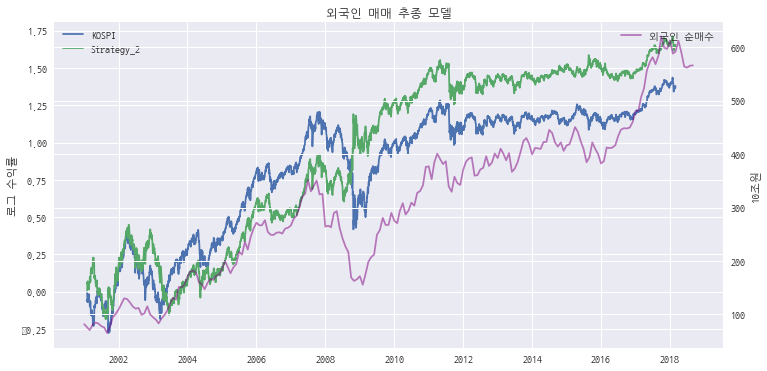

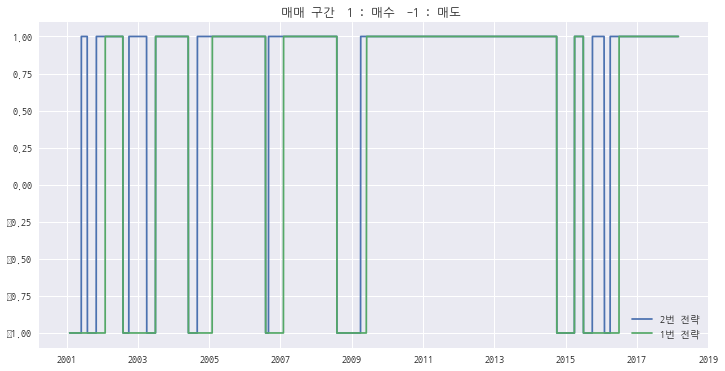

In [8]:
'''외국인 매수세가 3개월중 2개월 이상 상승세면 매수하는 전략으로 수정해보자'''

Strategy_2 = Frn.iloc[:,2:]

''' Signal은 Regime0,1,2의 값을 합산한 결과이다.

    Signal: 2,3 =   매수 신호     (외국인 순매수 3개월 중 2개월 이상 증가세)
    Signal: 1   = 포지션 유지     (외국인 매도세가 우세)
    Signal: 0   =   매도 신호     (외국인 순매수 3개월 연속 하락세) '''


Signal_2 = Strategy_2.sum(axis=1) ; Strategy_2['Signal_2'] = Signal_2

Strategy_2['Buy_2'] = np.where(Signal_2 > 1 , 1 , Strategy_2['Signal_2'])          #2,3
Strategy_2['Buy_2'] = np.where(Signal_2 < 2 , 0 , Strategy_2['Buy_2'])             #1,0  signal이 0인 경우 -1로 덮어씀
Strategy_2['Buy_2'] = np.where(Signal_2 < 1 , -1 , Strategy_2['Buy_2'])             # 0

''' Buy : 1     매수 신호
    Buy : 0     포지션 유지
    Buy : -1    매도 신호 (인버스 매수)  '''
    

''' Buy 값이 0 (포지션 유지) 인 경우, NaN으로 바꾼 후, 바로 위의 값으로 채워넣는다. ★(포지션 유지)'''
Strategy_2[Strategy_2['Buy_2'] == 0] = None
Strategy_2 = Strategy_2.fillna(method = 'ffill')

    
#코스피에 Buy_2 전략 매매신호 추가
kospi['Buy_2'] = Strategy_2['Buy_2']

#매매신호는 월단위 이므로 누락된 일별 매매신호를 채우자
kospi = kospi.fillna(method = 'ffill')

#전략의 수익률을 그려보자!
kospi['Strategy_2'] = kospi['log_return'] * kospi['Buy_2']


fig, ax = plt.subplots(figsize = (12,6))
ax.plot(kospi['log_return'].cumsum(), label = 'KOSPI')
ax.plot(kospi['Strategy_2'].cumsum(), label = 'Strategy_2')
ax.legend(loc = 'upper left')
ax.set_ylabel('로그 수익률')

ax2 = ax.twinx()
ax2.plot(Frn['Cummul'], color = 'purple', label = '외국인 순매수', alpha = 0.5)
ax2.legend(loc = 'upper right')
ax2.set_title('외국인 매매 추종 모델')
ax2.set_ylabel('10조원')

plt.figure(figsize = (12,6))
plt.plot(kospi['Buy_2'], label = "2번 전략")
plt.plot(kospi['Buy'], label = "1번 전략")
plt.legend(loc='best')
plt.title('매매 구간  1 : 매수  -1 : 매도 ')